# processing - new format

The datastream includes both data and features for every recorded samples.

In [1]:
import plotly.express as px

In [2]:
from nbimports import *

In [3]:
import processing
processing = reload(processing)

In [4]:
filename = "../data/user/data_29042022_180743.csv"

In [5]:
data = pd.read_csv(filename, index_col=0)
data.columns = ['source', 'data']

In [6]:
new_rows = []
default_value = np.ones(3) * np.nan

for i, row in data.iterrows():
    row = eval(row['data'].replace("false", "False"))

    key = row['sample_key']
    t0 = row['timestamp0']
    ts = row['timestamp']
    stroke_id = row['stroke_id']
    segment_id = row['segment_id']

    x, y, p = row.get('xyp', default_value)
    x_, y_, p_ = row.get('rel_xyp', default_value)
    x0, y0, p0 = row.get('rel_xyp_lp', default_value)
    x1, y1, p1 = row.get('xyp_sg', default_value)
    s = row['s']
    da = row['da']
    da = da[0] if isinstance(da, (list,)) else da
    
    new_row = [key, t0, ts, stroke_id, segment_id, x, y, p, x_, y_, p_, x0, y0, p0, x1, y1, p1, s, da]
    new_rows.append(new_row)

data_df = pd.DataFrame(data=new_rows, 
                    columns=['key', 't0', 'ts',
                             'stroke_id', 'segment_id',
                             'x', 'y', 'p', 'x_', 'y_', 'p_', 
                             'x0', 'y0', 'p0', 'x1', 'y1', 'p1',
                             's', 'da']
                   )

## figure all

In [7]:
data_df.head()

key       t0  ts  stroke_id  segment_id         x         y  \
0  3587199_50  3587199  50          8           0  0.345268  0.749269   
1  3587212_60  3587212  60          8           0  0.339485  0.747847   
2  3587225_70  3587225  70          8           0  0.331856  0.745303   
3  3587225_80  3587225  80          8           0  0.326874  0.742462   
4  3587238_90  3587238  90          8           0  0.321669  0.738565   

          p        x_        y_        p_        x0        y0        p0  \
0  0.022725 -0.006020  0.001405  0.000566 -0.000137  0.000054 -0.000137   
1  0.022137 -0.011803 -0.000016 -0.000022 -0.000386  0.000144 -0.000244   
2  0.021224 -0.019432 -0.002561 -0.000935 -0.000886  0.000298 -0.000351   
3  0.021136 -0.024414 -0.005402 -0.001023 -0.001761  0.000501 -0.000413   
4  0.019913 -0.029620 -0.009298 -0.002247 -0.003164  0.000673 -0.000406   

         x1        y1        p1         s   da  
0 -0.000052  0.000020 -0.000038  0.005605  0.0  
1 -0.000127  0.000044 -0.000059  0.013457  0.0  
2 -0.000264  0.000079 -0.000074  0.027557  0.0  
3 -0.000488  0.000115 -0.000074  0.050165  0.0  
4 -0.000828  0.000127 -0.000056  0.083717  0.0

<AxesSubplot:xlabel='x', ylabel='y'>

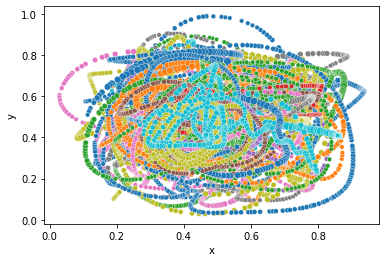

In [8]:
sns.scatterplot(data=data_df, x='x', y='y', size='p', hue='stroke_id', palette='tab10', legend=False)

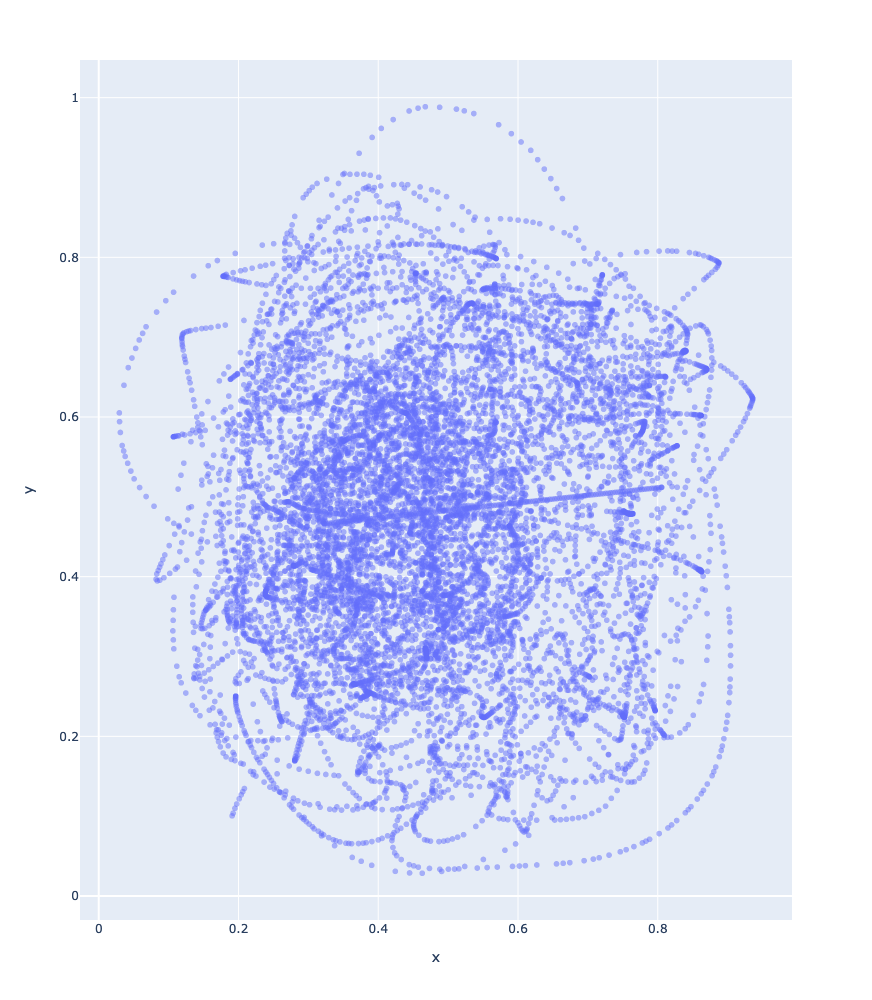

In [9]:
fig = px.scatter(x=data_df['x'], y=data_df['y'], opacity=0.5)
fig.layout.update(showlegend=False,
                  autosize=False,
                  width=1000,
                  height=1000,)
fig

## figure segments

In [10]:
import plotly.graph_objects as go

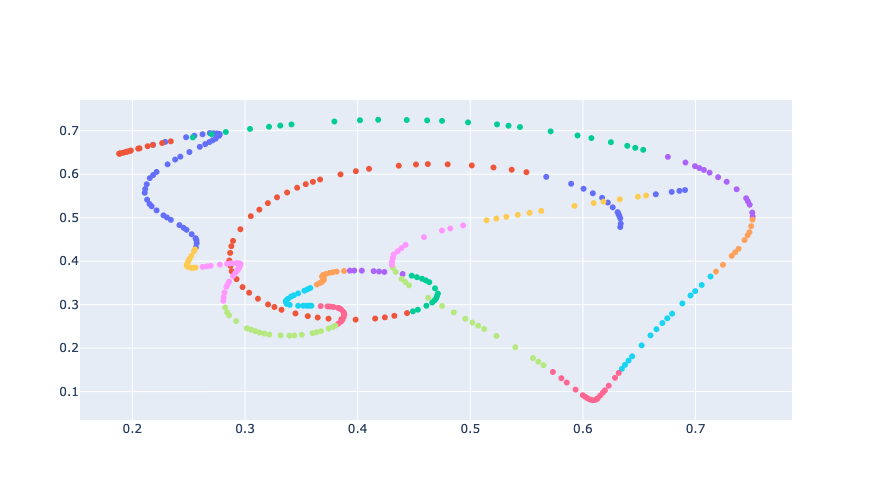

In [11]:
# select stroke
stroke_i = select(data_df, stroke_id=9)

if stroke_i.shape[0] > 0:
    # stroke_i_feat = stroke_i.join(df.set_index('key'), on='key').dropna()
    # if stroke_i_feat.shape[0] > 0:
    # p_scaled = mms.transform(stroke_i['p'].values.reshape(-1,1)).reshape(-1)
    colors = ["rgba"+str(tab10[int(i)%10]+(1,)) for i in stroke_i['segment_id']]
    fig = px.scatter(x=stroke_i['x'], y=stroke_i['y'], color=colors)

fig = go.Figure(data=fig.data)
fig.layout.update(
    showlegend=False,
    autosize=False,
    width=500,
    height=500,
)
fig

## clusterisation

In [14]:
import clusterisation

In [21]:
clusterisation = reload(clusterisation)

In [19]:
segments = [grp[['s', 'da']].values for i, grp in data_df.groupby('segment_id')]

In [17]:
import contextlib
import joblib
from tqdm import tqdm

In [18]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [27]:
from joblib import Parallel, delayed

with tqdm_joblib(tqdm(desc="My calculation", total=173166)) as progress_bar:
    # Parallel(n_jobs=16)(delayed(sqrt)(i**2) for i in range(10))
    sm_seg = clusterisation.compute_similarity_matrix(segments)

My calculation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173166/173166 [00:05<00:00, 30169.43it/s]


In [26]:
%%time
sm_seg = clusterisation.compute_similarity_matrix(segments)

In [23]:
import warnings

In [28]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    emb_seg = clusterisation.tsne_embed(sm_seg, perplexity=30) 

===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.6994, 50 iterations in 0.5108 sec
Iteration  100, KL divergence 2.6693, 50 iterations in 0.5120 sec
Iteration  150, KL divergence 2.6403, 50 iterations in 0.5033 sec
Iteration  200, KL divergence 2.6538, 50 iterations in 0.5052 sec
Iteration  250, KL divergence 2.6306, 50 iterations in 0.5051 sec
   --> Time elapsed: 2.54 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.7819, 50 iterations in 0.5175 sec
Iteration  100, KL divergence 0.6953, 50 iterations in 0.5146 sec
Iteration  150, KL divergence 0.6778, 50 iterations in 0.5121 sec
Iteration  200, KL divergence 0.6685, 50 iterations in 0.5099 sec
Iteration  250, KL divergence 0.6678, 50 iterations in 0.5179 sec
Iteration  300, KL divergence 0.6647, 50 iterations in 0.5369 sec
Iteration  350, KL divergence 0.6603, 50 iterations in 0.5802 sec
Iteration

In [34]:
emb_seg

TSNEEmbedding([[ -7.62422155,  -9.19552365],
               [  0.34167409,  13.0293241 ],
               [  1.35991283,  12.00228976],
               ...,
               [-13.40688089,  -0.1554252 ],
               [ 22.65840485, -10.60664133],
               [ 25.17974371,  -3.41103671]])

In [42]:
pd.DataFrame(emb_seg).iloc[:, 0].values

array([ -7.62422155,   0.34167409,   1.35991283,   3.88685894,
        -0.92469163,  -2.72905412, -19.47466571,  -3.69269976,
        -7.73864046,  -6.81778178,  -9.51906937, -10.24545031,
       -13.27518852,  -7.64041465, -14.43743805, -17.79159616,
       -22.5436329 , -23.82393387, -22.12932291,   7.69132182,
       -23.32904432, -23.58750262, -23.54034938,  -3.73475479,
       -22.78117239, -22.81276904,  -5.92717456, -21.81833162,
        -5.5000931 ,  -5.93615778, -22.85755226,   3.52556214,
         6.86309972,  -4.28405948,   6.70692196,   0.42216069,
       -16.75343685,   0.79388005,  13.89759543,  13.37374235,
         1.04858694,  -4.19477288,   0.22377963,   0.03464362,
         3.59324799, -16.86409893,  -4.08407786, -15.18189307,
       -19.94559692, -17.89439489,  19.33318769,  19.77102919,
        23.79722738,  21.62351372,  14.72169328,   1.13200144,
        -0.80696647, -15.99919794, -15.47393336,  -5.17586199,
        -8.3093407 , -22.84386267, -19.07729139, -17.29

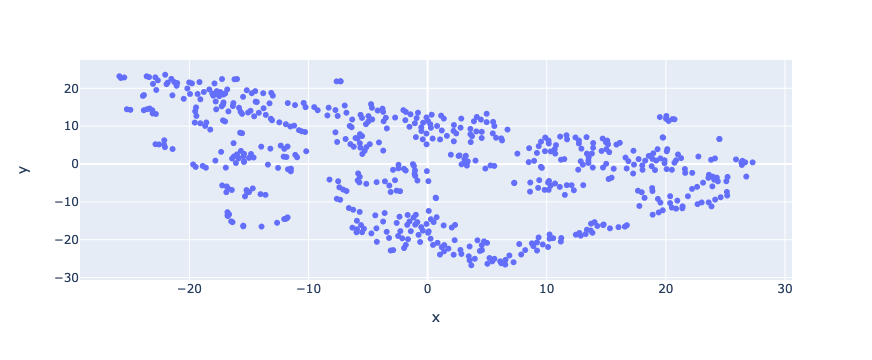

In [37]:
fig = px.scatter(data_frame=pd.DataFrame(emb_seg, columns=['x', 'y']), x='x', y='y')
fig

In [39]:
print(fig)

Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([ -7.62422155,   0.34167409,   1.35991283, ..., -13.40688089,
                           22.65840485,  25.17974371]),
              'xaxis': 'x',
              'y': array([ -9.19552365,  13.0293241 ,  12.00228976, ...,  -0.1554252 ,
                          -10.60664133,  -3.41103671]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y'}}}
})


In [44]:
data = {
  "points": [
    {
      "curveNumber": 0,
      "pointNumber": 0,
      "pointIndex": 0,
      "x": 1,
      "y": 1,
      "customdata": [
        1
      ]
    },
    {
      "curveNumber": 0,
      "pointNumber": 1,
      "pointIndex": 1,
      "x": 2,
      "y": 2,
      "customdata": [
        2
      ]
    },
    {
      "curveNumber": 1,
      "pointNumber": 0,
      "pointIndex": 0,
      "x": 1,
      "y": 3,
      "customdata": [
        3
      ]
    },
    {
      "curveNumber": 1,
      "pointNumber": 1,
      "pointIndex": 1,
      "x": 2,
      "y": 4,
      "customdata": [
        4
      ]
    }
  ],
  "range": {
    "x": [
      -0.21432565911389206,
      2.83302269645048
    ],
    "y": [
      -10.132553105304826,
      12.599768870565
    ]
  }
}

In [46]:
import json

In [48]:
json.dumps(data)

'{"points": [{"curveNumber": 0, "pointNumber": 0, "pointIndex": 0, "x": 1, "y": 1, "customdata": [1]}, {"curveNumber": 0, "pointNumber": 1, "pointIndex": 1, "x": 2, "y": 2, "customdata": [2]}, {"curveNumber": 1, "pointNumber": 0, "pointIndex": 0, "x": 1, "y": 3, "customdata": [3]}, {"curveNumber": 1, "pointNumber": 1, "pointIndex": 1, "x": 2, "y": 4, "customdata": [4]}], "range": {"x": [-0.21432565911389206, 2.83302269645048], "y": [-10.132553105304826, 12.599768870565]}}'